In [2]:
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../../../AutexysHost/source')
    
import numpy as np    
    
from utilities import DataLoggerUtility as dlu
from utilities import DataPlotterUtility as dpu
mplu = dpu.mplu
from utilities import FET_Modeling as fet_model
#from procedures import Device_History as DH

%config InlineBackend.figure_format = 'png'

0.3319501032568048 960
-0.10571647734685233 1440
-0.22531820954285164 1440
-0.15699187905096754 1440
Saving figures.
Figures saved. (Seconds elapsed: 0.4329400062561035)


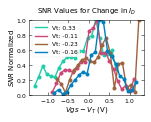

In [3]:
# define some AutoFlowStaticBias experiments that are good
SNR_experiment_names = [['C148FlowSaltWaterSNR/C148/G/35-36', 1, 'one'], 
                        ['C148Prelim/C148/G/17-18', 21, 'two'], 
                        ['C148FlowSaltWaterSNR/C148/A/9-10', 1, 'three'],
                        ['C148FlowSaltWaterSNR/C148/A/17-18', 1, 'four']]

'''
['C148FlowSaltWaterSNR/C148/G/24-25', 1, 'five'],
['C148FlowSaltWaterSNR/C148/G/47-48', 1, 'six'],
['C148FlowSaltWaterSNR/C148/A/4-5', 1, 'seven']
                
'''
colors = [mplu.setupColors(None, 20, colorMapName='white_teal_black', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='plasma', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='copper', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='winter', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greens', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Reds', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greys', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Oranges', colorMapStart=0.5, colorMapEnd=0.18)]

fig1, ax1 = dpu.makeBlankPlot(figsize=(2.2,1.8))
ax1.set_ylabel('$ Signal-Noise Ratio $')
ax1.set_ylim(0, 1)
experiment_counter = -1
legend = []

initial_vt = 0
for SNR_experiment in SNR_experiment_names:
    experiment_counter = experiment_counter + 1
    device_directory = SNR_experiment[0]
    device_number = SNR_experiment[1]
    
    data_long_gatesweep = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'GateSweep.json', minExperiment=device_number, maxExperiment=device_number) 
    data_long_fsb       = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'FlowStaticBias.json', minExperiment=device_number, maxExperiment=device_number) 

    SNR = []
    SNR_averaged_cycles = []
    SNR_total = []
    SNR_total_std = []
    allVgs = []
    
    # calculate average threshold voltage
    Vts = []
    for direction in range(0, 2):
        both_Vts = []
        for i in range(int(len(data_long_gatesweep)/(4/1)), int(len(data_long_gatesweep)/(4/3))):
            vgs_data = data_long_gatesweep[i]['Results']['vgs_data'][direction]    
            id_data = data_long_gatesweep[i]['Results']['id_data'][direction]
            bias_metrics = fet_model.FET_Metrics(vgs_data, id_data)
            V_T = bias_metrics['V_T']
            both_Vts.append(V_T)
        Vts.append(np.mean(both_Vts))
    Vt_average = np.mean(Vts)
    if experiment_counter == 0:
        initial_vt = np.mean(Vts)
        
    for i in range(len(data_long_fsb)):
        currentDevice = data_long_fsb[i]
        
        cycleCount = currentDevice["runConfigs"]["FlowStaticBias"]["cycleCount"]
        pumpPins = currentDevice["runConfigs"]["FlowStaticBias"]["pumpPins"]
        numberOfMotors = len(pumpPins)
        # this should be a constant value regardless
        currentVgs = np.mean(currentDevice["Results"]["vgs_data"]) 
        currentVds = np.mean(currentDevice["Results"]["vds_data"]) 
        
        # current data, with each index containing current data for each respective motor, in their own index for each cycle
        # id_data_total = [ [ [], [] ], [ [], [] ], [ [], [] ] ]
        # ^ with three cycles, with two motors
        id_data_total = []
        for cycleIndex in range(0, cycleCount):
            cycleArray = []
            for pinCount in range(0, numberOfMotors):
                cycleArray.append([])
            id_data_total.append(cycleArray)
        
        # go through pump_on_intervals_pin, add to proper id_data index based on where pin is
        counter = 0
        pinAlternatingCounter = 0
        measuredIdData = currentDevice["Results"]["id_data"]
        pump_on_intervals_pin = currentDevice["Results"]["pump_on_intervals_pin"]
        prevPin = pump_on_intervals_pin[0]

        for pumpIntervalCount in pump_on_intervals_pin:
            if prevPin != pumpIntervalCount:
                #print("counter: ", str(counter))
                pinAlternatingCounter += 1
                prevPin = pumpIntervalCount
                #print(int(pinAlternatingCounter / len(pumpPins)))
                
            variablename = int(pinAlternatingCounter / len(pumpPins))
            id_data_total[ variablename ][pumpPins.index(pumpIntervalCount)].append(measuredIdData[counter])
            counter += 1
        
        # calculate signal to noise ratio!
        # The assumption here is that the FIRST pin is the control
        
        # SNR: each index represents noise per cycle; each array in respective index represents SNR b/w control and 
        # solutions outputted from digitalPins as ordered in pumpPins
        SNR = []
        
        for cycleIndex in range(0, cycleCount):
            individualPumpRatio = []
            #print("cycle count: ", str(cycleIndex))
            # go through every other pin, compare to control
            for pinIndex in range(1, len(pumpPins)):
                control_data = id_data_total[cycleIndex][0]
                control_data = control_data[int(len(control_data)*1/4):int(len(control_data)*3/4)]
                other_data = id_data_total[cycleIndex][pinIndex]
                other_data = other_data[int(len(other_data)*1/4):int(len(other_data)*3/4)]
                u1 = np.mean(control_data)
                u2 = np.mean(other_data)
                #print("means")
                #print(u1, u2)
                
                signal = abs(u1 - u2)
                std1 = np.std(control_data)
                std2 = np.std(other_data)
                noise = (std1 + std2) / 2

                individualPumpRatio.append(signal / noise)
            SNR.append(individualPumpRatio)
        #print("SNR")
        #print(SNR)
        
        # go through every possible pin combination (i), and average up the cycles (k)
        SNR_averaged_cycles = []
        SNR_averaged_cycles_std = []
        for i in range(0, len(pumpPins)-1):
            SNR_averaged_cycles.append([])
            SNR_averaged_cycles_std.append([])
            for k in range(1, cycleCount):
                SNR_averaged_cycles[i].append(SNR[k][i])
            a = np.mean(SNR_averaged_cycles[i])
            b = np.std(SNR_averaged_cycles[i])
            SNR_averaged_cycles[i] = a
            SNR_averaged_cycles_std[i] = b
                    
            SNR_total.append(SNR_averaged_cycles)
            SNR_total_std.append(SNR_averaged_cycles_std)
            
        allVgs.append(currentVgs)

    SNR_total = [k / np.max(SNR_total) for k in SNR_total]
    print(Vt_average, counter)
    for x in range(0, len(pumpPins)-1):
        correspondingSNR = []
        snr_max_per = 0
        snr_max_per_index = 0
        ax1.plot([x - (Vt_average) for x in allVgs], SNR_total, color=colors[experiment_counter][0], label='Vt: ' + str(round(Vt_average, 2)))
        for y in range(0, len(allVgs)):
            correspondingSNR.append(SNR_total[y][x])
            ax1.plot([allVgs[y] - (Vt_average)], [SNR_total[y][x]], color=colors[experiment_counter][0], linestyle=None, linewidth=0, marker='o', markersize=4)
            #ax1.errorbar([allVgs[y] - Vt_average], [SNR_total[y][x]], yerr=SNR_total_std[y][x], color=colors[experiment_counter][0], linewidth=1, capsize=2, capthick=0.5, elinewidth=0.5)
            if SNR_total[y][x] > snr_max_per:
                snr_max_per = SNR_total[y][x]
                snr_max_per_index = y
        #ax1.axvline(allVgs[snr_max_per_index])

ax1.legend()
file_name = 'SNRPlotNotebookTotal'
ax1.set_xlabel('$ Vgs - V_{{T}} $ (V)')
ax1.set_ylabel('$ SNR $ Normalized')
ax1.set_title('SNR Values for Change in $I_{{D}}$')
dpu.saveExternalPlot(fig1, file_name)